# Introdução

No mundo cada vez mais conectado em que vivemos,  cantores, atores, celebridades e pessoas famosas em geral possuem um papel fundamental em diversos movimentos e discussões sociais. De modo que, suas ações e palavras são referência para milhares de jovens e adultos do que é certo, errado, do que é bom e do que é ruim. Sendo assim, é muito importante entender e refletir sobre que tipo de mensagem esses artistas estão passando para as pessoas.


Pensando nisso esse trabalho teve como intuito identificar quais palavras são mais usadas por algumas das artistas femininas mais influentes na  atualidade: **Rihanna, Lady Gaga, Beyoncé, Lorde, Nicki Minaj, Sia**.
Para isso, foi preciso selecionar as letras das 20 principais músicas de cada artista e separar palavra por palavra e assim criar um grafo com nós que representam as artistas e as palavras de cada música. De maneira mais específica, o estudo pode ser feito para cada artista, mas como o intuito é identificar as palavras mais usadas por elas, no final haverá um grafo contendo todas as artistas e as palavras contidas nas letras e o nó terá um tamanho proporcional ao grau.

# Metodologia

Para a realização desse projeto utilizou-se a técnica de Web Scraping que, em resumo, consiste na extração de dados diretamente de um ou mais sites da web, e para relizar essa extração teve-se o auxílio da biblioteca BeautifulSoup. Além disso, realizou-se a análise das informações obtidas por meio de grafos e  redes, que foram construídos com o uso das seguintes bibliotecas: Networkx,  Matplotlib e nxviz. 

De uma maneira mais específica,  o código em html do site <a href='https://www.vagalume.com.br/'>Vagalume</a> foi resgatado para capturar as 20 principais músicas de cada uma das cantoras mencionadas. A partir disso, foi possível obter apenas as letras das canções, e consequentemente a ocorrência de cada palavra pôde ser contabilizada.

# Preparação das bases

## Bibliotecas necessárias

In [0]:
!pip install git+https://github.com/ericmjl/nxviz

In [0]:
from bs4 import BeautifulSoup
import requests
import networkx as nx
import matplotlib.pyplot as plt
from nxviz import CircosPlot 

## Resgatando as letras das 10 principais músicas de cada artista


Esse tópico fica dedicado para resgatar as letras das 20 principais músicas das cantoras Rihanna, Sia, Lorde, Lady Gaga, Beyoncé e Adele.

In [0]:
artistas = ["rihanna", 'lady-gaga', 'beyonce', 'lorde', 'adele', 'sia']

respostas = [requests.get("https://www.vagalume.com.br/"+name) for name in artistas]
contents = [resposta.content for resposta in respostas]
parsers = [BeautifulSoup(content, 'html.parser') for content in contents]
listas_links = [parser.find_all("a", "nameMusic") for parser in parsers]

In [0]:
artista_links = {}
i = 0
for i in range(len(artistas)):
  artista = artistas[i]
  artista_links[artista] = [j['href'].split('/'+artista)[1] for j in listas_links[i]]

In [0]:
def remove_repeated_musics(data):
  for i in data:
    if('remix' in i): # Se for remix, a música deverá ser desconsiderada
      data.remove(i)
  return data

In [0]:
for artista in artista_links.keys():
  artista_links[artista] = remove_repeated_musics(artista_links[artista])[:20] # Pega somente as 20 primeiras músicas

### Limpando as letras

Aqui as músicas passam por uma limpeza a fim de remover partes desnecessárias que não serão analizadas.

In [0]:
# Algumas músicas tem algumas partes que indicam quem vai começar a cantar, caso seja um 'featuring'
def remove_btwen_brackets(music):
  final_music = ''
  music = music.split('[')
  for i in range(len(music)):
    if(']' not in music[i]):
      final_music += music[i]
    else:
      final_music += music[i].split(']')[1]
  return final_music
  

In [0]:
# Removendo caracteres especiais
def clear_music(music):
  music = str(music).casefold()
  music = music.replace('<div id=\"lyrics\">','')
  music = music.replace('<div data plugin=\"googletranslate\" id=\"lyrics\">','')
  
  music = music.replace(',', ' ')
  music = music.replace('</div>',' ')
  music = music.replace('(',' ')
  music = music.replace(')',' ')
  music = music.replace('?', ' ')
  music = music.replace('!', ' ')
  music = music.replace('..', ' ')
  
  music = music.replace('\'ve', ' have')
  music = music.replace('\'m', ' am')
  music = music.replace('\'re', ' are')
  music = music.replace('\'s', ' is')
  music = music.replace('don\'t', 'do not')
  music = music.replace('\'ll', ' will')
  music = music.replace('\'til', 'until')
  music = music.replace('y\'all', 'you all')
  music = music.replace('gon\'', 'gonna')
  music = music.replace('\'d', ' would')
  music = music.replace('\'cuz', 'because')
  
  music = music.replace('cause', 'because')
  music = music.replace('lovei', 'love')
  
  music = music.replace('-', ' ')
  music = music.replace('<br/>', ' ')
  
  return remove_btwen_brackets(music)

In [0]:
def remove_double_white_spaces(music):
  final_music = ''
  music = music.split(' ')
  
  while('' in music):
    music.pop(music.index(''))
  
  for i in range(len(music)):
    if(i != len(music)-1):
      final_music += '{} '.format(music[i])
    else:
      final_music += '{}'.format(music[i])
      
  return final_music

In [0]:
def take_lyrics(artist, music):
  response = requests.get("https://www.vagalume.com.br/"+artist + music)
  content = response.content
  parser = BeautifulSoup(content, 'html.parser')
  lyrics = parser.find_all('div', id="lyrics")
  return clear_music(lyrics[0])

In [0]:
artistas_musicas = {artista:[take_lyrics(artista, music) for music in musica] for artista, musica in artista_links.items()}

# Criando multigrafos para termos mais utilizados por artista


In [0]:
# Criar o multigrafo
networks = {}
for artista, musicas in artistas_musicas.items():
  graph = nx.MultiGraph()
  for musica in musicas:
    for word in musica.split(' '):
      if(len(word) > 3):
        graph.add_edge(artista, word)
  networks[artista] = graph

In [0]:
# Selecionar apenas palavras que aparecem mais de 20 vezes
final_networks = {}
final_networks['geral'] = nx.MultiGraph()
for network in networks:
  graph = nx.MultiGraph()
  for node in networks[network]:
    if networks[network].degree(node) > 20 and networks[network].degree(node) < 1000:
      graph.add_edge(network, node, networks[network].degree(node))
    if  networks[network].degree(node) > 1000 :
      graph.add_edge(network, node, 100)
  final_networks[network] = graph   

### Rihanna

In [0]:
# Definindo os parâmetros
node_size = [node[2]*100 for node in final_networks['rihanna'].edges]
pos = nx.spring_layout(final_networks['rihanna'])

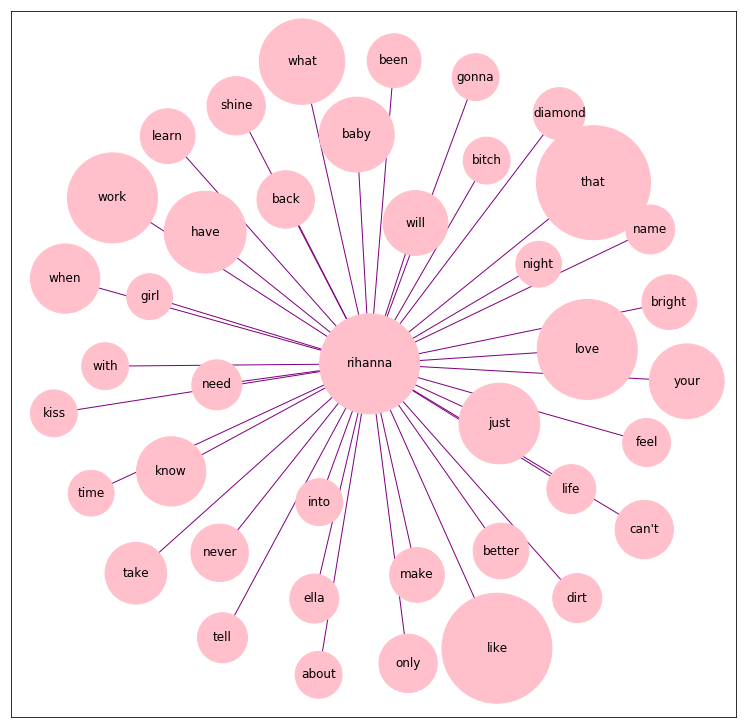

In [29]:
# Plotando a Rede
fig, plot = plt.subplots(figsize=(13,13))
nx.draw_networkx(final_networks['rihanna'], pos=pos, ax=plot, node_size=node_size,  node_color='pink', edge_color='purple')
plt.show()

### SIA


In [0]:
# Definindo os parâmetros
node_size = [node[2]*150 for node in final_networks['sia'].edges]
pos = nx.spring_layout(final_networks['sia'])

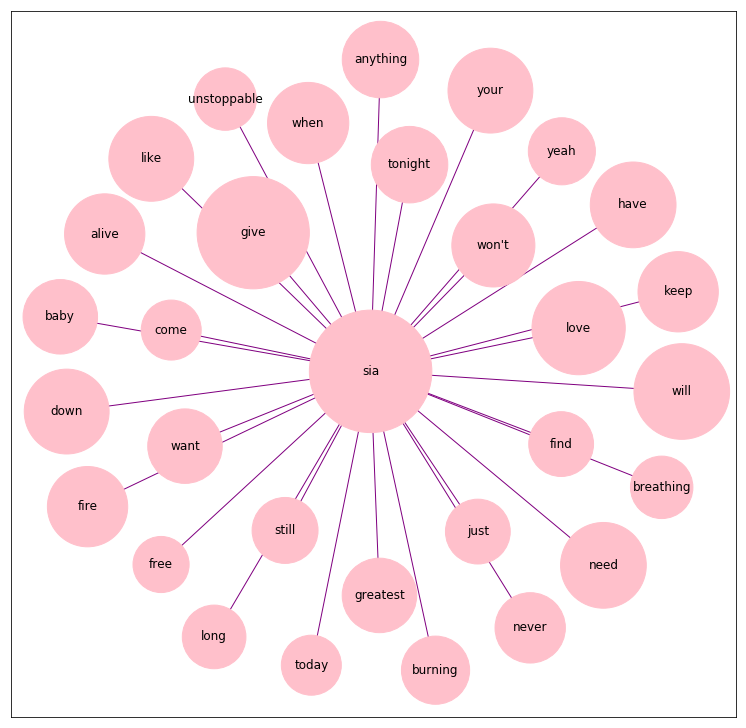

In [31]:
# Plotando a Rede
fig, plot = plt.subplots(figsize=(13,13))
nx.draw_networkx(final_networks['sia'], pos=pos, ax=plot, node_size=node_size, node_color='pink', edge_color='purple')
plt.show()

### Adele


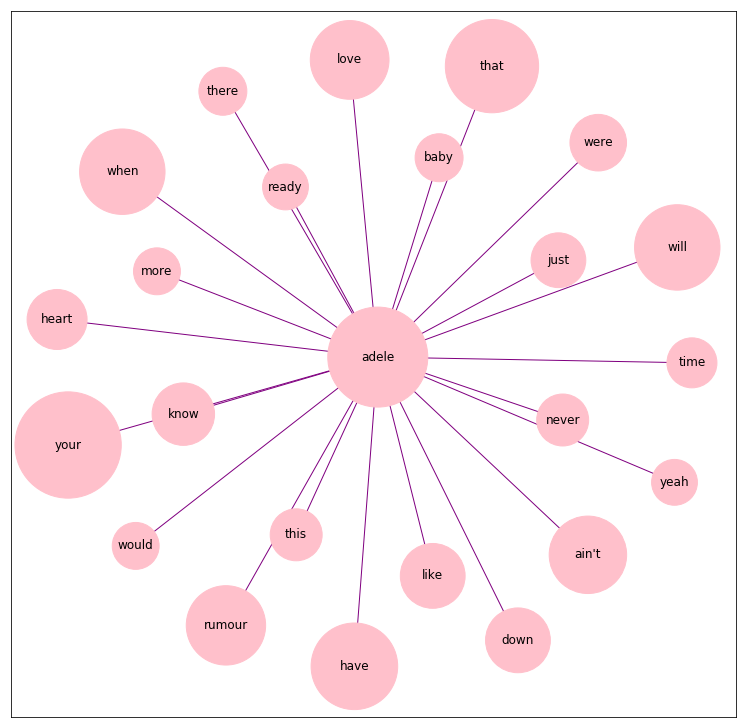

In [32]:
name = "adele"
node_size = [node[2]*100 for node in final_networks[name].edges]
pos = nx.spring_layout(final_networks[name])
fig, plot = plt.subplots(figsize=(13,13))
nx.draw_networkx(final_networks[name], pos=pos, ax=plot, node_size=node_size,  node_color='pink', edge_color='purple')
plt.show()

### Beyoncé

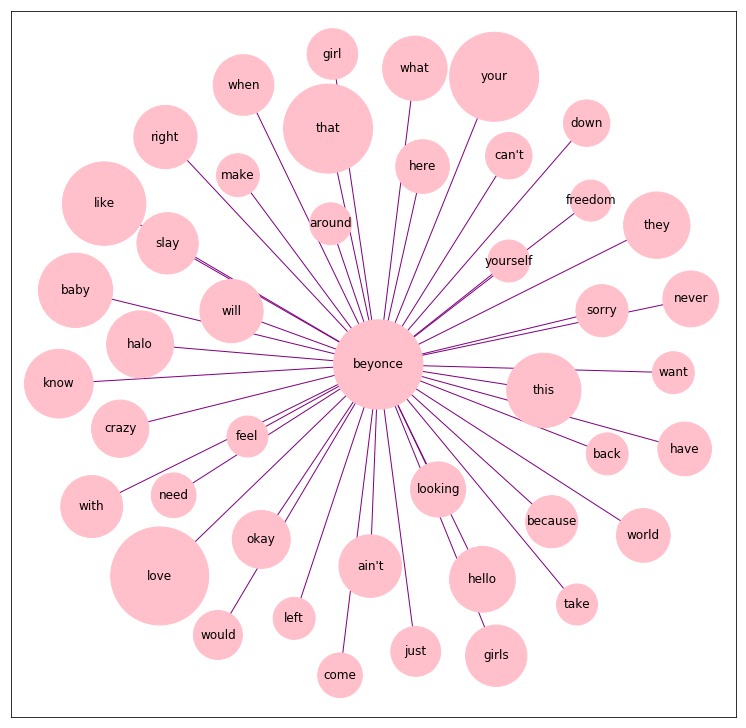

In [33]:
# Definindo os parâmetros
name = "beyonce"
node_size = [node[2]*80 for node in final_networks[name].edges]
pos = nx.spring_layout(final_networks[name])
fig, plot = plt.subplots(figsize=(13,13))
nx.draw_networkx(final_networks[name], pos=pos, ax=plot, node_size=node_size,  node_color='pink', edge_color='purple')
plt.show()

### Lorde

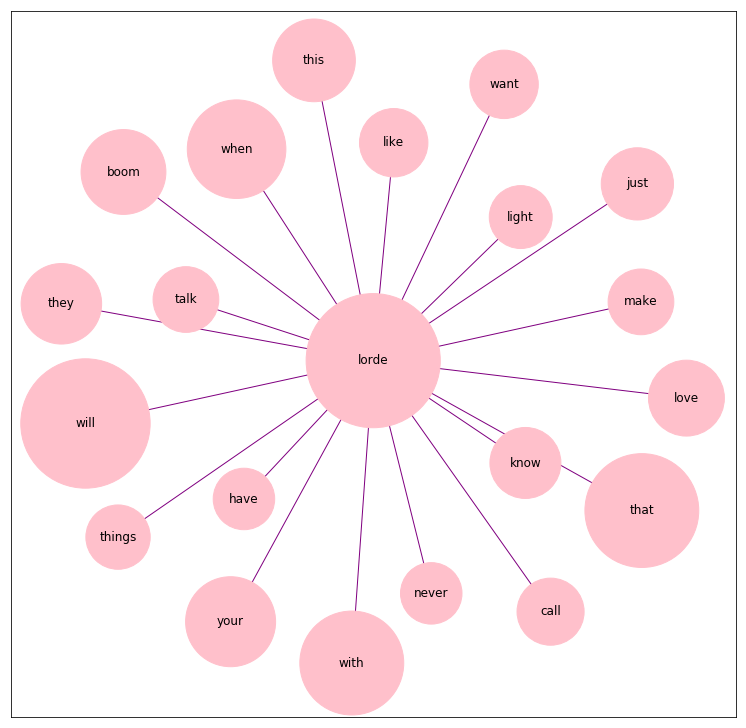

In [34]:
name = "lorde"
node_size = [node[2]*180 for node in final_networks[name].edges]
pos = nx.spring_layout(final_networks[name])
fig, plot = plt.subplots(figsize=(13,13))
nx.draw_networkx(final_networks[name], pos=pos, ax=plot, node_size=node_size,  node_color='pink', edge_color='purple')
plt.show()

### Lady Gaga

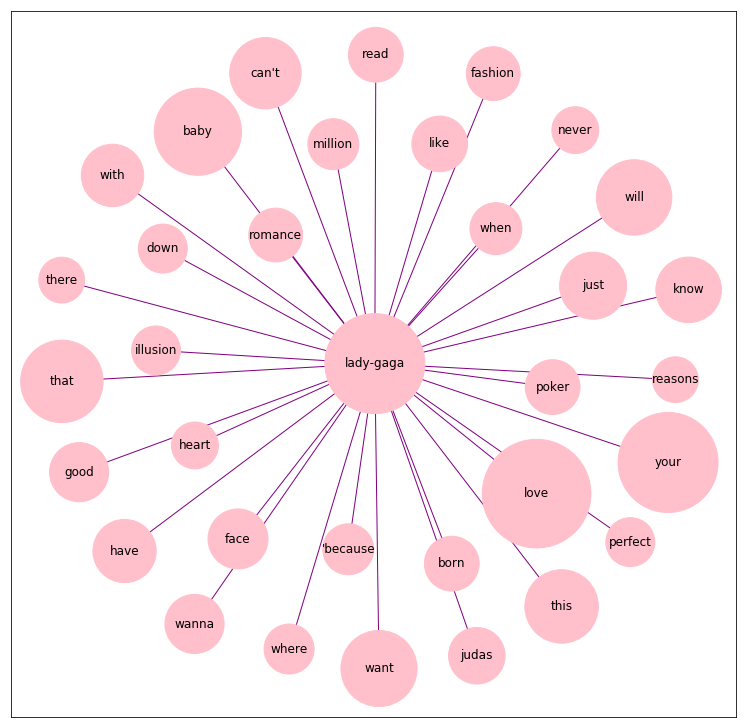

In [35]:
name = "lady-gaga"
node_size = [node[2]*100 for node in final_networks[name].edges]
pos = nx.spring_layout(final_networks[name])
fig, plot = plt.subplots(figsize=(13,13))
nx.draw_networkx(final_networks[name], pos=pos, ax=plot, node_size=node_size,  node_color='pink', edge_color='purple')
plt.show()

### Geral

In [0]:
# Gerar grafo geral
geral = nx.MultiGraph()
for artista, musicas in artistas_musicas.items():
  for musica in musicas:
    for word in musica.split(' '):
      if(len(word) > 3):
        geral.add_edge(artista, word)

In [0]:
# Selecionar apenas palavras que aparecem mais de 80 vezes
general_graph = nx.MultiGraph()
for edge in geral.edges:
  if edge[2] > 60:
    general_graph.add_edge(edge[0], edge[1], edge[2])
    

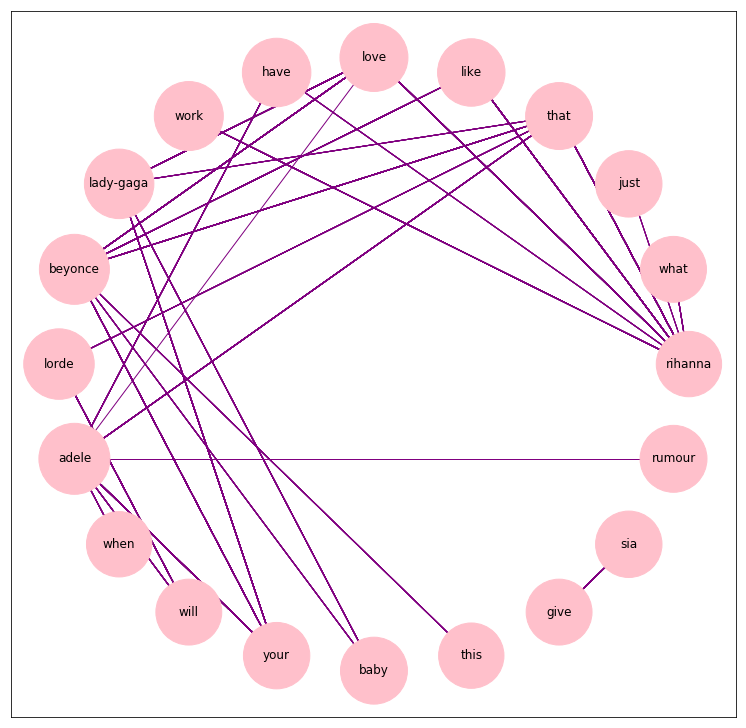

In [38]:
node_size = [node[2]*70 for node in general_graph.edges]
pos = nx.circular_layout(general_graph)
fig, plot = plt.subplots(figsize=(13,13))
nx.draw_networkx(general_graph, pos=pos, ax=plot, node_size=node_size, node_color='pink', edge_color='purple' )
plt.show()